# Введение в искусственные нейронные сети
# Урок 3. TensorFlow

## Практическое задание

  1. Постройте нейронную сеть(берем простую линейную сеть, которую разбирали на уроке: меняем число слоев, число нейронов , типы активации, тип оптимизатора)  на датасет from sklearn.datasets import load_boston. 
  2. Измените функцию потерь и метрику для этой задачи. Постройте 10-15 вариантов и сведите результаты их работы в таблицу  Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

  3. Поработайте с документацией TensorFlow 2. Найти 2-3 полезные команды TensorFlow, не разобранные на уроке (полезные для Вас).

  1-2. (*)  Попробуйте обучить нейронную сеть на TensorFlow 2 на датасете imdb_reviews . Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

### Набор данных для последнего ДЗ

- COVID 19 диагностика https://www.kaggle.com/andrewmvd/covid19-ct-scans

- Распознавание изображений цифр в представлении языка жестов https://www.kaggle.com/ardamavi/sign-language-digits-dataset


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
# from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import boston_housing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

### Загрузка датасета

#### Описание датасета

* данные: содержит информацию для различных домов
* целевая переменная: MEDV (цены домов в тысячах долларов)


 Набор содержит 13 признаков:
 * CRIM:     Уровень преступности на душу населения
 * ZN:       Доля жилой земли, выделенной для участков более 25 000 квадратных футов
 * INDUS:    Доля не торговых бизнес акров на город
 * CHAS:     Переменная реки Чарлз (равна 1 если рядом река, 0 если нет)
 * NOX:      Концентрация оксидов азота (частей на 10 миллионов)
 * RM:       Среднее количество комнат на жилье
 * AGE:      Пропорция домов частных владельцев, построенных до 1940 года
 * DIS:      Взвешенные расстояния до пяти рабочих центров Бостона
 * RAD:      Индекс доступности близлежащих автомагистралей
 * TAX:      Полная стоимость налога на имущество на 10 000 долларов США
 * PTRATIO:  Среднее количество учителей для детей на город
 * B        1000(Bk - 0.63)^2 , где Bk - это пропорция афроамериканцев на город
 * LSTAT:    Процент населения с низким социальным статусом


In [3]:
(train_data,train_labels),(test_data,test_labels)=boston_housing.load_data()

print('train_data.shape', train_data.shape)  #(404, 13)
print('test_data.shape ', test_data.shape)  #(102, 13)

57026/57026 [==============================] - 0s 0us/step
train_data.shape (404, 13)
test_data.shape  (102, 13)


In [4]:
# данные имеют разные масштабы
print(train_data[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


In [5]:
print(train_labels[0])

15.2


In [6]:
# Нормализация.
scaler = MinMaxScaler((-1,1))
X_train = scaler.fit_transform(train_data)
X_test = scaler.transform(test_data)

print(X_train[0])  # Первый тренировочный пример, нормализованный

[-9.72436739e-01 -1.00000000e+00 -4.36950147e-01 -1.00000000e+00
 -3.70370370e-01 -3.87296669e-04  8.29042225e-01 -4.05617544e-01
 -7.39130435e-01 -5.44933078e-01  7.87234043e-01  1.00000000e+00
 -6.23620309e-02]


Т.к. это явно задача регрессии, то в последнем слое линейная активационная функция, а loss - среднеквадратичные потери.

Для проведения дальнейших тестов, чтобы было интереснее, напишем функцию сравнения нескольких активацонных функций и оптимизаторов с прочими равными параметрами

In [7]:
def get_experiment(nol=2, non=10, epochs=10, batch_size=1):

    # nol - количество внутренних слоев
    # non - количество нейронов во всех слоях, кроме последнего
    # epochs -  количество эпох
    # batch_size - количество примеров в батче

    activations = ['linear', 'relu', 'tanh', 'sigmoid']
    optimizers = ['adam', 'sgd', 'RMSprop']

    plt.figure(figsize=(16, 8))
    result_dense = []

    for act_f in activations:
        for opti in optimizers:

            # print(f'Тестирование модели активация: {act_f}, оптимизатор: {opti}')

            # Шаблон сети
            layers_list = None # Чтобы точно очистить от возможного мусора
            layers_list = [Dense(non, activation=act_f, input_shape=(13,)),]
            for i in range(nol-1):
                layers_list += [Dense(non, activation=act_f)]
            layers_list +=  [Dense(1, activation='linear')]

            boston_model = Sequential(layers_list)

            boston_model.compile(optimizer=opti,
                                loss='mean_squared_error',
                                metrics=['mean_squared_error', 'accuracy'])

            # boston_model.summary()
            history = boston_model.fit(X_train, train_labels,
                              epochs=epochs,
                              batch_size=batch_size, 
                              validation_split=0.2,
                              verbose = 0
                            )
            
            # Коэффициент детерминации на предсказании тестовой выборки
            y_test_pred = boston_model.predict(X_test, verbose = 0)
            try:
                test_metric = r2_score(test_labels, y_test_pred)
                # print( f'test_metric: {test_metric}')
            except ValueError:
                test_metric = np.NaN
            # [loss, mae] = boston_model2.evaluate(test_data, test_labels, verbose=0)
            # print("Testing set Mean Abs Error: ${:7.2f}".format(mae * 1000))       

            # накопление результатов
            mod_name = f'активация: {act_f}, оптимизатор: {opti}'
            mod_metric = history.history['mean_squared_error'][epochs-1]
            mod_val_metric = history.history['val_mean_squared_error'][epochs-1]
            result_dense.append([mod_name, mod_metric, mod_val_metric, test_metric])
    
            plt.plot(history.history['val_mean_squared_error'] ,label=f'val ({act_f}, {opti})')
            plt.plot(history.history['mean_squared_error'], '--' ,label=f'train ({act_f}, {opti})')
            plt.legend()
            plt.xlabel('epoch')
            plt.ylabel('mean_squared_error')
            # plt.ylim(0, 0.2)
            plt.title('метрика MSE сети от эпох')

    # Визуализация результата
    plt.show()

    return result_dense

### Вариант расчета модели № 1

* Количество слоев, кроме выходного - 2
* количество нейронов в слое - 5
* 10 эпох по 1 примеру в батче

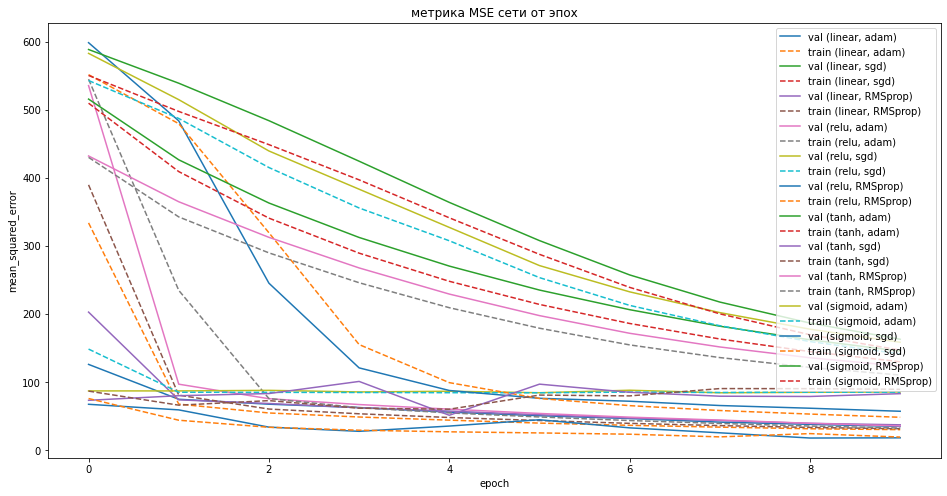

In [29]:
result = get_experiment(nol=2, non=5, epochs=10, batch_size=1)

In [30]:
pd.DataFrame(result, columns=['mod_name','mod_metric','mod_val_metric', 'test_metric']).sort_values('mod_val_metric',ascending=True)

,mod_name,mod_metric,mod_val_metric,test_metric
10,"активация: sigmoid, оптимизатор: sgd",19.675261,18.566813,0.653656
0,"активация: linear, оптимизатор: adam",30.540897,35.233059,0.707903
3,"активация: relu, оптимизатор: adam",32.900677,35.950790,0.668877
2,"активация: linear, оптимизатор: RMSprop",31.902153,37.657955,0.701126
5,"активация: relu, оптимизатор: RMSprop",48.700706,57.524384,0.469726
7,"активация: tanh, оптимизатор: sgd",89.767914,83.339149,-0.076293
4,"активация: relu, оптимизатор: sgd",85.560181,85.877831,-0.004287
8,"активация: tanh, оптимизатор: RMSprop",110.643890,123.818626,-0.390975
6,"активация: tanh, оптимизатор: adam",130.156235,145.748184,-0.639365
9,"активация: sigmoid, оптимизатор: adam",141.700272,158.750977,-0.778107


Немного неожиданный результат. Лучшее обучение получилось у пары активационная функция "sigmoid" и оптимизатора "sgd"

## Вариант расчета модели № 2

* Количество слоев, кроме выходного - 5
* количество нейронов в слое - 5
* 10 эпох по 1 примеру в батче

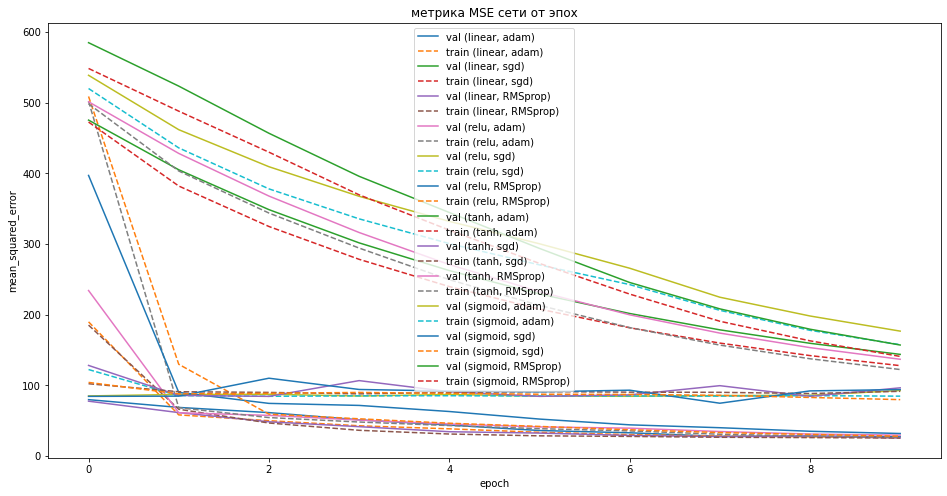

In [32]:
result = get_experiment(nol=5, non=5, epochs=10, batch_size=1)

In [33]:
pd.DataFrame(result, columns=['mod_name','mod_metric','mod_val_metric', 'test_metric']).sort_values('mod_val_metric',ascending=True)

,mod_name,mod_metric,mod_val_metric,test_metric
2,"активация: linear, оптимизатор: RMSprop",25.619715,25.735743,0.730461
0,"активация: linear, оптимизатор: adam",26.135965,27.330729,0.750313
3,"активация: relu, оптимизатор: adam",26.737894,29.740189,0.679572
5,"активация: relu, оптимизатор: RMSprop",28.175295,32.025867,0.721253
4,"активация: relu, оптимизатор: sgd",84.828156,92.797523,-0.064078
10,"активация: sigmoid, оптимизатор: sgd",79.928696,94.163918,-0.077414
7,"активация: tanh, оптимизатор: sgd",91.662125,96.639809,-0.101979
8,"активация: tanh, оптимизатор: RMSprop",122.482086,136.992340,-0.535471
6,"активация: tanh, оптимизатор: adam",127.994560,143.930878,-0.612503
11,"активация: sigmoid, оптимизатор: RMSprop",141.024170,157.137421,-0.760058


## Вариант расчета модели № 3

* Количество слоев, кроме выходного - 3
* количество нейронов в слое - 10
* 200 эпох по 1 примеру в батче

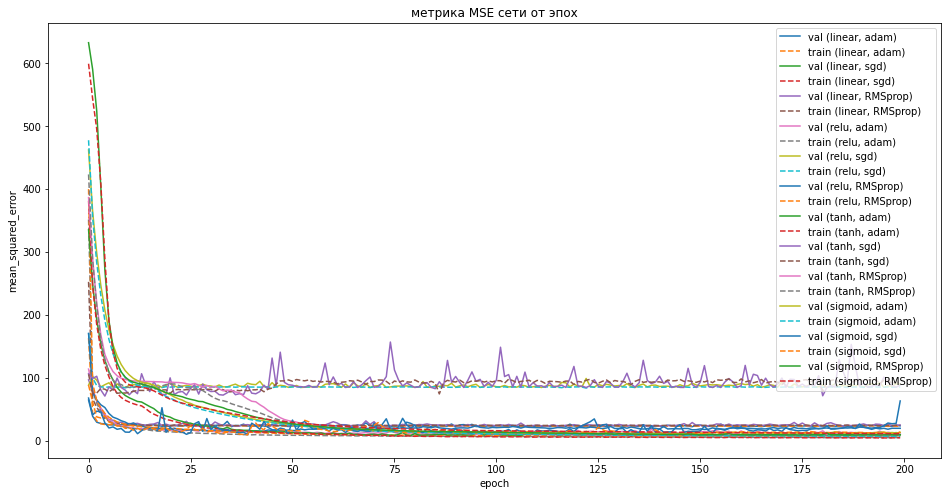

In [34]:
result = get_experiment(nol=3, non=10, epochs=200, batch_size=1)

In [35]:
pd.DataFrame(result, columns=['mod_name','mod_metric','mod_val_metric', 'test_metric']).sort_values('mod_val_metric',ascending=True)

,mod_name,mod_metric,mod_val_metric,test_metric
11,"активация: sigmoid, оптимизатор: RMSprop",11.180974,9.349927,0.744425
6,"активация: tanh, оптимизатор: adam",4.733749,9.430310,0.790533
3,"активация: relu, оптимизатор: adam",4.826537,9.617890,0.819820
8,"активация: tanh, оптимизатор: RMSprop",7.211509,12.303566,0.740773
9,"активация: sigmoid, оптимизатор: adam",6.969728,13.209641,0.696146
5,"активация: relu, оптимизатор: RMSprop",6.801940,19.629631,0.756581
0,"активация: linear, оптимизатор: adam",22.964836,23.609251,0.715184
2,"активация: linear, оптимизатор: RMSprop",24.063196,24.888273,0.753280
10,"активация: sigmoid, оптимизатор: sgd",14.018600,63.122177,0.080068
7,"активация: tanh, оптимизатор: sgd",92.688469,88.494797,-0.024431


При данных настройках как-то очень посредственно показал себя оптимизатор sgd.
А вот активация relu с оптимизатором adam стабильно на 3-м месте. И значительно улучшила значение по метрике.

## Вариант расчета модели № 4

* Количество слоев, кроме выходного - 10
* количество нейронов в слое - 50
* 100 эпох по 1 примеру в батче

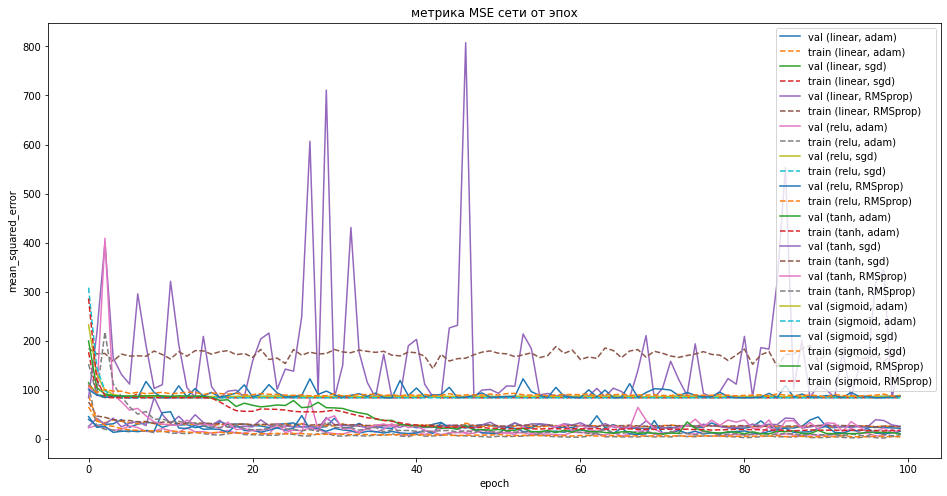

In [36]:
result = get_experiment(nol=10, non=50, epochs=100, batch_size=1)

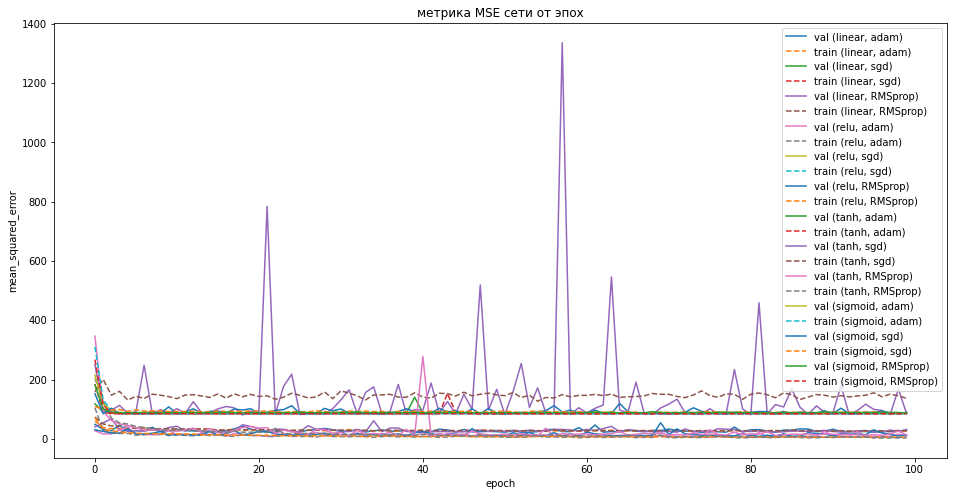

In [8]:
result = get_experiment(nol=10, non=50, epochs=100, batch_size=1)

In [9]:
pd.DataFrame(result, columns=['mod_name','mod_metric','mod_val_metric', 'test_metric']).sort_values('mod_val_metric',ascending=True)

,mod_name,mod_metric,mod_val_metric,test_metric
3,"активация: relu, оптимизатор: adam",3.316365,9.545586,0.839632
5,"активация: relu, оптимизатор: RMSprop",5.119093,13.091911,0.820730
8,"активация: tanh, оптимизатор: RMSprop",5.051657,13.161428,0.725642
0,"активация: linear, оптимизатор: adam",25.250063,28.263708,0.675519
2,"активация: linear, оптимизатор: RMSprop",26.569569,31.832386,0.651667
7,"активация: tanh, оптимизатор: sgd",136.379852,85.301010,0.038227
9,"активация: sigmoid, оптимизатор: adam",84.390930,86.556274,-0.008868
6,"активация: tanh, оптимизатор: adam",84.516571,86.636375,-0.009452
11,"активация: sigmoid, оптимизатор: RMSprop",84.706100,87.145691,-0.013312
10,"активация: sigmoid, оптимизатор: sgd",87.805801,89.310387,-0.031570


sgd стабильно борется за последние позиции в рейтинге. Видимо для этой задачи он не очень применим.

активационна функция tanh тоже ведет себя не стабильно (судя по графику) и тоже, скорее всего, не подходит для решения этой задачи. Хотя, может я просто не опытен. И настройка каких-то "магических" и неизвестных мне пока параметров сможет изменить ситуацию.

Зато отмеченный ранее ванриант (relu, adam) вообще вышел на первое место. Продемонстрировав результат, сопостовимый с предыдущим примером.

## Вывод по анализу разобранных примеров.

Как мне кажется, лучшим выбором для этой задачи может быть связка (relu, adam). При этом, минимальное качество обучения для метрики "средняя квадратичная ошибка" можно достичь на сети из 5 слоев по 15 нейронов в каждом. И на длительности обучения в 50 эпох.

## Модель с 10-15 вариантами комбинаций функции потерь и метрик

Проведем тот-же эксперимнет для сети чьи характеристики описаны в выводе выше.

In [ ]:
(train_data,train_labels),(test_data,test_labels)=boston_housing.load_data()

# Перемешаем тренировочные данные
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

In [10]:
# Нормализация
scaler = MinMaxScaler((-1,1))
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

* активации relu
* функция потерь - среднеквадратичная ошибка, средняя абсолютная ошибка, средняя абсолютная ошибка в процентах
* метрика - среднеквадратичная ошибка, средняя абсолютная ошибка, средняя абсолютная ошибка в процентах
* 50 эпох по 1 примеру в батче

In [12]:
model = Sequential([
    Dense(15, activation='relu', input_shape=(train_data.shape[1],)),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(15, activation='relu'),
    Dense(1, activation='linear')
])

epochs = 50 #  количество эпох
batch_size = 1 # количество примеров в батче

result = []

# сетка параметров
loss_space = ['MSE', 'MAE', 'MAPE', 'MSLE']
metrics_space = ['MSE', 'MAE', 'MAPE', 'MSLE']

for loss_item in loss_space:
    for metrics_item in metrics_space:
    
        model.compile(optimizer='adam',
                             loss=loss_item,
                             metrics=[metrics_item])
        
        model.fit( train_data, train_labels,
                        epochs=epochs,
                        batch_size=batch_size, 
                        validation_split=0.2,
                        verbose = 0
                        )
        
        y_test_pred = model.predict(test_data)
        
        [loss, metric] = model.evaluate(test_data, test_labels, verbose=0)
               
        # накопление результатов
        result.append([loss_item, loss, metrics_item, metric, r2_score(test_labels, y_test_pred)])   

4/4 [==============================] - 0s 4ms/step


In [13]:
# Оценки на тестовой выборке
pd.DataFrame(result, columns=['loss_item','loss',
                              'metrics_item', 'metric',
                              'r2_score(test_labels, y_test_pred)']).\
                              sort_values('r2_score(test_labels, y_test_pred)',ascending=False).head(10)

,loss_item,loss,metrics_item,metric,"r2_score(test_labels, y_test_pred)"
5,MAE,2.921449,MAE,2.921449,0.768825
10,MAPE,14.613581,MAPE,14.613581,0.762670
13,MSLE,0.039275,MAE,2.917737,0.754560
6,MAE,2.948596,MAPE,14.848203,0.754033
12,MSLE,0.037919,MSE,20.775406,0.750427
1,MSE,20.962893,MAE,3.061086,0.748175
11,MAPE,15.495915,MSLE,0.040388,0.744617
9,MAPE,13.878301,MAE,3.001948,0.741338
0,MSE,21.931761,MSE,21.931761,0.736536
15,MSLE,0.046013,MSLE,0.046013,0.734314


## Вывод 

Лучший результат показала пара (loss: MAE, metric: MAE). И результат лучше, чем MSE, который использовался в первом задании. Видимо, для данной задачи регрессии абсолютная ошибка и лосс - то, что нужно.

## Вывод  по всему ДЗ

1. Нейронные сети - это не волшебный оракул, который знает все ответы и умеет предсказывать буду.... результат в будущих экспериментах.
2. Необходоим достаточно много ресурсов и времени, для проведения всех экспериментов.
3. Желательно бы иметь опыт.
4. Желательно иметь хорошо предобработанные данные для обучения.

5. Удалось добиться результата, при котором сеть угадывает цену жилья с точностью плюс/минус 3 000 $. В жизни, это приемлимая дельта.
6. Улучшить точность помгло большое количество экспериментов. Смелость при подборе параметров. Достаточно мощьные (для данной задачи) ресурсы Google Colab.

На самом деле улучшить результат работы нейросети помог внимательный анализ результатов, полученных на предыдущих шагах.